## Point Polygon Matching Process Example

This notebook gives an example of how the matching script matches the address points to the building footprints. Visualization code blocks are for example purposes only and are not part of the script itself. See matching_master.py for the script in its working format. 

In [3]:
%matplotlib inline
import os
import geoplot as gplt
import contextily as cx
import re
import string
import sys
from pathlib import Path
import fiona
import geopandas as gpd
import numpy as np
from numpy.core.numeric import True_
from operator import add, index, itemgetter
sys.path.insert(1, os.path.join(sys.path[0], ".."))
import pandas as pd
from pyproj import crs
from shapely import geometry
from shapely.geometry import MultiPolygon, Point, Polygon, geo
from dotenv import load_dotenv
import datetime
pd.options.mode.chained_assignment = None

#### Load in key variables from environments file

In [4]:
load_dotenv(os.path.join(r'C:\projects\point_in_polygon\scripts', 'NB_environments.env'))

output_path = os.getcwd()
output_gpkg = Path(os.getenv('MATCHED_OUTPUT_GPKG'))
matched_lyr_nme = os.getenv('MATCHED_OUTPUT_LYR_NME')
unmatched_lyr_nme = os.getenv('UNMATCHED_OUTPUT_LYR_NME')
unmatched_poly_lyr_nme = os.getenv('UNMATCHED_POLY_LYR_NME')

# Layer inputs cleaned versions only
project_gpkg = Path(os.getenv('DATA_GPKG'))
footprints_lyr_nme = os.getenv('CLEANED_BF_LYR_NAME')
addresses_lyr_nme = os.getenv('FLAGGED_AP_LYR_NME')

proj_crs = int(os.getenv('PROJ_CRS'))

add_num_fld_nme =  os.getenv('AP_CIVIC_ADDRESS_FIELD_NAME')
unlinked_bf_lyr_nme = os.getenv('UNLINKED_BF_LYR_NME')

out_lyr_nme = os.getenv('LINKED_BY_DATA_NME')

buffer_size = 20 # distance for the buffer

metrics_out_path = Path(os.getenv('METRICS_CSV_OUT_PATH'))

bp_threshold = int(os.getenv('BP_THRESHOLD'))
bp_area_threshold = int(os.getenv('BP_AREA_THRESHOLD'))

#### Step 1. Load in data

Load in key layers necessary for the matching process. Below each layer is a visualization of each layer as well as an sample of the key attributes used in the matching process.

In [13]:
addresses = gpd.read_file(project_gpkg, layer=addresses_lyr_nme, crs=proj_crs)
addresses.to_crs(crs= proj_crs, inplace=True)


The imported data is visualized in the cell below

   link_field    parcel_rel                        geometry
0     15669.0  many_to_many  POINT (682878.278 5091377.881)
1      8090.0    one_to_one  POINT (681469.292 5091242.104)
2      5450.0  many_to_many  POINT (687609.116 5086246.165)
3      5450.0  many_to_many  POINT (687422.883 5086473.461)
4      5450.0  many_to_many  POINT (687411.578 5086451.094)


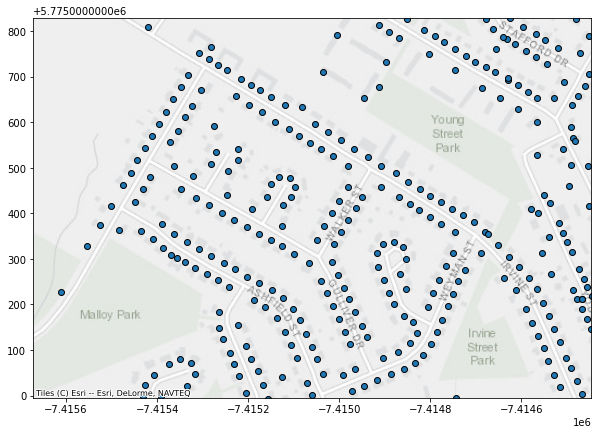

In [25]:
vis_aoi = gpd.read_file(r'C:\projects\point_in_polygon\data\NB_data\vis_aoi.shp')
vis_aoi.to_crs(crs=3857, inplace=True)

minx, miny, maxx, maxy = vis_aoi.total_bounds

df_plt =addresses.to_crs(crs=3857).plot(figsize=(10,10), edgecolor='k')
df_plt.set_xlim(minx, maxx)
df_plt.set_ylim(miny, maxy)
cx.add_basemap(df_plt,zoom=16, source= cx.providers.Esri.WorldGrayCanvas)

print(addresses[['link_field', 'parcel_rel', 'geometry']].head())


In [21]:
footprint = gpd.read_file(project_gpkg, layer=footprints_lyr_nme, crs=proj_crs)
footprint.to_crs(crs=proj_crs, inplace=True)

print(footprint[['link_field','geometry']].head())
gplt.polyplot(footprint.to_crs(crs=4326), extent=extent)

   link_field                                           geometry
0     10889.0  MULTIPOLYGON (((680899.743 5088742.860, 680899...
1      8355.0  POLYGON ((681172.269 5090741.306, 681174.316 5...
2      8735.0  POLYGON ((683250.460 5092295.094, 683252.493 5...
3     15563.0  POLYGON ((684870.089 5087571.354, 684869.072 5...
4     19226.0  POLYGON ((675701.626 5094019.200, 675711.068 5...


NameError: name 'extent' is not defined

#### Step 2. Configure address to building polygon linkage

In the next step the goal is to determine the linkage between the address point and building polygon. This is done by using several methods. First, a list is created of all building polygons that match the link_field value of each given address point. This is compiled as a list in the addresses dataframe as the field footprint_index.

In [ ]:
def groupby_to_list(df, group_field, list_field):
    
    """
    Helper function: faster alternative to pandas groupby.apply/agg(list).
    Groups records by one or more fields and compiles an output field into a list for each group.
    """
    
    if isinstance(group_field, list):
        for field in group_field:
            if df[field].dtype.name != "geometry":
                df[field] = df[field].astype("U")
        transpose = df.sort_values(group_field)[[*group_field, list_field]].values.T
        keys, vals = np.column_stack(transpose[:-1]), transpose[-1]
        keys_unique, keys_indexes = np.unique(keys.astype("U") if isinstance(keys, np.object) else keys, 
                                              axis=0, return_index=True)
    
    else:
        keys, vals = df.sort_values(group_field)[[group_field, list_field]].values.T
        keys_unique, keys_indexes = np.unique(keys, return_index=True)
    
    vals_arrays = np.split(vals, keys_indexes[1:])
    
    return pd.Series([list(vals_array) for vals_array in vals_arrays], index=keys_unique).copy(deep=True)

# Define join fields.
join_footprint = 'link_field'
join_addresses = 'link_field'


# Link addresses and footprint on join fields.

addresses["addresses_index"] = addresses.index
footprint["footprint_index"] = footprint.index

# Remove buildings flagged as sheds as they do not need to be matched
footprint = footprint[footprint['shed_flag'] == False]

merge = addresses[~addresses[join_addresses].isna()].merge(footprint[[join_footprint, "footprint_index"]], how="left", left_on=join_addresses, right_on=join_footprint)

addresses['footprint_index'] = groupby_to_list(merge, "addresses_index", "footprint_index")
addresses.drop(columns=["addresses_index"], inplace=True)

A sample of the results of the above process can be seen printed out below.

In [ ]:
print(addresses['footprint_index'].head())

There are cases where there are lots of small buildings on a parcel each containing a single address. Examples of this are trailer parks and Indigenous Reserves the nature of the data in these areas is such that using data linking is not the most accurate method of creating a match. In these cases we utilize the 'big parcel' method where these parcels are isolated and a proximity buffer is used for each point to create a single match. The records are filtered out from the main addresses dataset as they have been matched.

Below are the key functions for making this process work: 

In [ ]:
def building_area_theshold_id(building_gdf, bf_area_threshold , area_field_name='bf_area'):
    '''
    Returns a boolean on whether a majority of the buildings in the bp fall under the bp threshold defined in the environments. 
    Buildings should be filtered to only those in the polygon before being passed into this function
    '''
    
    all_bf_cnt = len(building_gdf)

    bf_u_thresh = building_gdf[building_gdf[area_field_name] <= bf_area_threshold]
    bf_u_thresh_cnt = len(bf_u_thresh)

    if bf_u_thresh_cnt >= (all_bf_cnt/2):
        return True
    else:
        return False
    

def get_unlinked_geometry(addresses_gdf, footprint_gdf , buffer_distance:int):
    'Returns indexes for the bf based on the increasing buffer size'
    
    def list_bf_indexes(buffer_geom, bf_gdf):
        """
        For parcel-less bf geometry takes the buffer from the buffer_geom field and looks for 
        intersects based on the buffer geom. Returns a list of all indexes with true values.
        """
        intersects = bf_gdf.intersects(buffer_geom)
        intersects = intersects[intersects == True]
        intersects = tuple(intersects.index)
        if len(intersects) > 0:
            return intersects
        else: 
            return np.nan
    
    addresses_gdf['buffer_geom'] = addresses_gdf.geometry.buffer(buffer_distance)
    addresses_gdf[f'footprint_index'] = addresses_gdf['buffer_geom'].apply(lambda point_buffer: list_bf_indexes(point_buffer, footprint_gdf))

    linked_df = addresses_gdf.dropna(axis=0, subset=[f'footprint_index'])
    linked_df['method'] = f'{buffer_distance}m buffer'
    linked_df.drop(columns=["buffer_geom"], inplace=True)
    addresses_gdf = addresses_gdf[~addresses_gdf.index.isin(list(set(linked_df.index.tolist())))]
    return linked_df


def get_nearest_linkage(ap, footprint_indexes):
    """Returns the footprint index associated with the nearest footprint geometry to the given address point."""  
    # Get footprint geometries.
    footprint_geometries = tuple(map(lambda index: footprint["geometry"].loc[footprint.index == index], footprint_indexes))
    # Get footprint distances from address point.
    footprint_distances = tuple(map(lambda footprint: footprint.distance(ap), footprint_geometries))                                     
    distance_values = [a[a.index == a.index[0]].values[0] for a in footprint_distances if len(a.index) != 0]
    distance_indexes = [a.index[0] for a in footprint_distances if len(a.index) != 0]

    if len(distance_indexes) == 0: # If empty then return drop val
        return np.nan

    footprint_index =  distance_indexes[distance_values.index(min(distance_values))]
    return footprint_index

In the step below the following actions occur. First a count is created for all building polygons and address points by link_id. This gives a count of how many address points and building polygons are in a given parcel. This number is then compared against the bp_threshold. The bp_threshold is the number of ojects of each type that must be present in order to meet the criteria to go through the bp process. 

Next for any records that meet the bp criteria another check is performed. This checks to see if the majority of buildings   

In [ ]:
# Big Parcel (BP) case extraction (remove and match before all other cases)
bf_counts = footprint.groupby('link_field', dropna=True)['link_field'].count()
ap_counts = addresses.groupby('link_field', dropna=True)['link_field'].count()
# Take only parcels that have more than the big parcel (bp) threshold intersects of both a the inputs
addresses_bp = addresses.loc[(addresses['link_field'].isin(bf_counts[bf_counts > bp_threshold].index.tolist())) & (addresses['link_field'].isin(ap_counts[ap_counts > bp_threshold].index.tolist()))]

if len(addresses_bp) > 0:
    # return all addresses with a majority of the buildings under the area threshold
    addresses_bp['u_areaflag'] = addresses_bp['footprint_index'].apply(lambda x: building_area_theshold_id(footprint[footprint['footprint_index'].isin(x)], bp_area_threshold)) 
    addresses_bp = addresses_bp.loc[addresses_bp['u_areaflag'] == True]
    addresses_bp.drop(columns=['u_areaflag'], inplace=True)

    addresses =  addresses[~addresses.index.isin(addresses_bp.index.tolist())]
    addresses_bp = get_unlinked_geometry(addresses_bp, footprint, buffer_distance=buffer_size)

    # Find and reduce plural linkages to the closest linkage
    ap_bp_plural = addresses_bp['footprint_index'].map(len) > 1
    addresses_bp.loc[ap_bp_plural, "footprint_index"] = addresses_bp[ap_bp_plural][["geometry", "footprint_index"]].apply(lambda row: get_nearest_linkage(*row), axis=1)
    addresses_bp.loc[~ap_bp_plural, "footprint_index"] = addresses_bp[~ap_bp_plural]["footprint_index"].map(itemgetter(0))
    addresses_bp['method'] = addresses_bp['method'].astype(str) + '_bp'


Now we return to configuring the linkages on the remainder of the records. Some addresses do not fall within a parcel and do not have a parcel linkage. These are separated out and checked using a proximity buffer method. 

In [ ]:
# Extract non-linked addresses if any.
addresses_na = addresses[addresses['footprint_index'].isna()] # Special cases with NaN instead of a tuple
addresses = addresses[~addresses.index.isin(addresses_na.index.tolist())]

unlinked_aps = addresses[addresses["footprint_index"].map(itemgetter(0)).isna()] # Extract unlinked addresses
if len(addresses_na) > 0:    
    unlinked_aps = unlinked_aps.append(addresses_na) # append unlinked addresses to the addresses_na

# Separate out for the buffer phase
addresses.drop(addresses[addresses["footprint_index"].map(itemgetter(0)).isna()].index, axis=0, inplace=True)

#### Step 3. Checking address linkages via intersects

In this step the first set of matches are made on the address dataset as a whole. The first method used is whether the point directly intersects the building polygon

In [ ]:
def check_for_intersects(address_pt, footprint_indexes):
    '''Similar to the get nearest linkage function except this looks for intersects (uses within because its much faster) and spits out the index of any intersect'''
    footprint_geometries = tuple(map(lambda index: footprint["geometry"].loc[footprint.index == index], footprint_indexes))
    inter = tuple(map(lambda bf: address_pt.within(bf.iloc[0]), footprint_geometries))
    if True in inter:
        t_index = inter.index(True)
        return int(footprint_geometries[t_index].index[0])

In [ ]:
addresses['intersect_index'] = addresses[["geometry", "footprint_index"]].apply(lambda row: check_for_intersects(*row), axis=1)
# Clean footprints remove none values and make sure that the indexes are integers
intersections = addresses.dropna(axis=0, subset=['intersect_index'])

addresses = addresses[addresses.intersect_index.isna()] # Keep only address points that were not intersects
addresses.drop(columns=['intersect_index'], inplace=True) # Now drop the now useless intersects_index column

intersect_a_points = list(set(intersections.intersect_index.tolist()))

addresses.dropna(axis=0, subset=['footprint_index'], inplace=True)

intersections['intersect_index'] = intersections['intersect_index'].astype(int)

intersect_indexes = list(set(intersections.index.tolist()))

intersections['footprint_index'] = intersections['intersect_index']
intersections.drop(columns='intersect_index', inplace=True)
intersections['method'] = 'intersect'


#### Step 4. Create Address Linkages Using Linking Data

In the code block below all plural linkages from the data linking method are exploded so that each linkage gets its own unique row. This creates a linkage for every building in the list. 

In [ ]:
def as_int(val):
    "Step 4: Converts linkages to integer tuples, if possible"
    try:
        if isinstance(val, int):
            return val
        else:
            return int(val)
    except ValueError:
        return val

# Convert linkages to integer tuples, if possible.
addresses["footprint_index"] = addresses["footprint_index"].map(lambda vals: tuple(set(map(as_int, vals))))

# Flag plural linkages.
flag_plural = addresses["footprint_index"].map(len) > 1
addresses = addresses.explode('footprint_index') # Convert the lists into unique rows per building linkage (cleaned up later)

addresses = addresses[addresses['footprint_index'] != np.nan]
addresses['method'] = 'data_linking'

Next all buildings that did not recieve a linkage in the previous steps are now put through a process where a linkage is attempted to be created through the use of a buffer. As with the big parcel step in cases where the linkage is plural the closest building to the addresses point is taken as the match. Two different methods are used at this stage:

1.) If an address point does not fall in a parcel it is only compared aginst buildings that have yet to recieve a match.
2.) If an address point falls within a parcel it is compared against all buildings regardless of other matches

This difference in method used is due to certain types of buildings crossing parcel boundaries and having valid addresses in both parcels (ex. semi detached houses). Address points that fall outside of a parcel are more often then not, unrelated to nearby buildings already linked to an address point

In [ ]:
if len(unlinked_aps) > 0:
    
    unlinked_aps.to_crs(proj_crs, inplace=True)
    unlinked_aps.drop(columns=['footprint_index'], inplace=True)

    # split into two groups = points linked to a parcel - run against full building dataset, points with no footprint - only run against unlinked buildings
    no_parcel = unlinked_aps[unlinked_aps['link_field'].isna()]
    parcel_link = unlinked_aps[~unlinked_aps['link_field'].isna()]

    # get all footprint_indexes (fi) from the previous steps to exclude in the next step for no parcel aps
    intersect_fi = list(set(intersections.footprint_index.tolist()))
    linking_fi = list(set(addresses.footprint_index.tolist()))

    # Bring in only those footprints that haven't yet been matched to remove matches on buildings already matched
    unlinked_footprint = footprint[~(footprint['footprint_index'].isin(linking_fi) | footprint['footprint_index'].isin(intersect_fi))]

    # run the next line using only the footprints that are not already linked to an address point
    no_parcel = get_unlinked_geometry(no_parcel, unlinked_footprint, buffer_size)
    parcel_link = get_unlinked_geometry(parcel_link, footprint, buffer_size)
    
    # Grab those records that still have no link and export them for other analysis
    unmatched_points = unlinked_aps[~((unlinked_aps.index.isin(list(set(no_parcel.index.to_list())))) | (unlinked_aps.index.isin(list(set(parcel_link.index.to_list())))))]
    
    unlinked_aps = no_parcel.append(parcel_link)
    # Take only the closest linkage for unlinked geometries
    unlinked_plural = unlinked_aps['footprint_index'].map(len) > 1
    unlinked_aps.loc[unlinked_plural, "footprint_index"] = unlinked_aps[unlinked_plural][["geometry", "footprint_index"]].apply(lambda row: get_nearest_linkage(*row), axis=1)
    unlinked_aps = unlinked_aps.explode('footprint_index')
    unlinked_aps['method'] = f'{buffer_size}m_buffer'

#### Step 5. Merge and Export Results

All possible matches have now been made. In the step below all matched records are merged into a single dataset and exported for manual review. All data that could not be linked for one reason or another is also exported into their own layers for review via other processes. 

In [ ]:
def create_centroid_match(footprint_index, bf_centroids):
    '''Returns the centroid geometry for a given point'''
    new_geom = bf_centroids.iloc[int(footprint_index)]
    return new_geom

In [ ]:
outgdf = addresses.append([intersections, addresses_bp, unlinked_aps])

# Create representitive points for the building polygons
footprint['centroid_geo'] = footprint['geometry'].apply(lambda bf: bf.representative_point())
print('     Matching address points with footprint centroids')
outgdf['out_geom'] = outgdf['footprint_index'].apply(lambda row: create_centroid_match(row, footprint['centroid_geo']))

outgdf = outgdf.set_geometry('out_geom')

outgdf.drop(columns='geometry', inplace=True)
outgdf.rename(columns={'out_geom':'geometry'}, inplace=True)
outgdf = outgdf.set_geometry('geometry')

footprint.drop(columns='centroid_geo', inplace=True)

# Find unlinked building polygons
unlinked_footprint = footprint[~footprint['footprint_index'].isin(outgdf['footprint_index'].to_list())]

# Export unlinked building polygons
unlinked_footprint.to_file(output_gpkg, layer=unmatched_poly_lyr_nme, driver='GPKG')

# Export matched address geometry
outgdf.to_file(output_gpkg, layer=matched_lyr_nme,  driver='GPKG')
# Export unmatched address geometry
unmatched_points.to_file(output_gpkg, layer=unmatched_lyr_nme, driver='GPKG')